## Offensive comment classifier

In [1]:
#Import some key Python libraries for data analysis (Pandas and Numpy)
import pandas as pd
import numpy as np
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.RESERVED, p.OPT.MENTION,p.OPT.SMILEY,p.OPT.NUMBER)

In [2]:
#Import the data into a dataframe
df_training = pd.read_csv('offenseval-training-v1.tsv', sep='\t')

In [3]:
df_training.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [4]:
#For task (a) we are interested in columns 1 and 2, so let's drop 0, 3 and 4
df_training = df_training.drop(df_training.columns[[0, 3, 4]], axis=1)
df_training.columns=['tweet','label']

In [5]:
df_training.head()

,tweet,label
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,Amazon is investigating Chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT


In [6]:
#Let's understand the data a bit more
df_training.describe()

,tweet,label
count,13240,13240
unique,13207,2
top,@USER Looks Like The Jokes On Liberals Again. ...,NOT
freq,6,8840


In [7]:
df_training.columns=['tweet','label']

From: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html

For object data (e.g. strings or timestamps), the result’s index will include count, unique, top, and freq. The top is the most common value. The freq is the most common value’s frequency. Timestamps also include the first and last items.

If multiple object values have the highest count, then the count and top results will be arbitrarily chosen from among those with the highest count.
        

In [8]:
df_training.describe()

,tweet,label
count,13240,13240
unique,13207,2
top,@USER Looks Like The Jokes On Liberals Again. ...,NOT
freq,6,8840


#### Import test set

In [9]:
df_test_tweets = pd.read_csv('testset-taska.tsv', sep='\t')
df_test_labels = pd.read_csv('labels-test-a.csv', header=None)

df_test_tweets=df_test_tweets.drop(df_test_tweets.columns[[0]],axis=1)
df_test_labels=df_test_labels.drop(df_test_labels.columns[[0]], axis=1)

In [10]:
df_training.head()

,tweet,label
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,Amazon is investigating Chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT


## Step 1: Preprocess the data, mainly data cleaning

In [11]:
#Split out the data, putting two two columns into two separate lists (so we don't cheat)
tweets = []
tweet_labels = []
tweets = df_training['tweet']
tweet_labels = df_training['label']
tweets.head()

0    @USER She should ask a few native Americans wh...
1    @USER @USER Go home you’re drunk!!! @USER #MAG...
2    Amazon is investigating Chinese employees who ...
3    @USER Someone should'veTaken" this piece of sh...
4    @USER @USER Obama wanted liberals &amp; illega...
Name: tweet, dtype: object

In [12]:
for i in range(len(tweets)):
    tweets.iloc[i]=p.clean(tweets.iloc[i])

In [13]:
tweets.head()

0    She should ask a few native Americans what the...
1      Go home you’re drunk!!! #MAGA #Trump2020 🇺🇸 URL
2    Amazon is investigating Chinese employees who ...
3    Someone should'veTaken" this piece of shit to ...
4    Obama wanted liberals &amp; illegals to move i...
Name: tweet, dtype: object

In [14]:
df_test_labels.columns=['label']
test_tweets=df_test_tweets['tweet']
test_labels=df_test_labels['label']
for i in range(len(test_tweets)):
    test_tweets.iloc[i]=p.clean(test_tweets.iloc[i])

## Step 2: Vectorise the data

We'll initialise a scikit-learn vector with the `CountVectorizer` class.  The data could be formatted in many different ways but as a start let's set it to lower case and exclude some common stop words.

The vectorizer will convert the data into vectors of features. As we'll use a `CountVector` the features are counts of the words that occur in the dataset.  We'll then fit the vectoriser onto our data and concert it to an array.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', lowercase = False,)
#vectorizer = CountVectorizer(min_df=4)
X_train=vectorizer.fit_transform(tweets)
X_test=vectorizer.transform(test_tweets)

#features = vectorizer.fit_transform(tweets)
#features_nd = features.toarray() # for easy usage

Define training and test set

In [16]:
y_train=tweet_labels
y_test=test_labels

## Step 3: Build a Classifier model

# 1 - Logistic Regression

There are many classifier models we could (and should) build and test.  We'll start with a simple model from Scikit-learn `LogisticRegression`.

In [17]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()

In [18]:
X_test.shape, X_train.shape

((860, 24086), (13240, 24086))

That's an empty model. Now let's train it to our specific dataset.  We'll use the scikit-learn `fit` method to get the ML classifier to *learn* the underlying functions that produce our results.

In [19]:
log_model = log_model.fit(X=X_train, y=y_train)

C:\Users\Aijaz\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [20]:
y_pred=log_model.predict(X_test)
y_pred.shape

(860,)

### Testing accuracy

Just looking at the data is a poor method to gauge accuracy and there are clearly some misclassifications.
Let's use scikit learn to calculate an accuracy score.

`sklearn.metrics.accuracy_score` will help us calculate what percentage of tweets are classified correctly.

In [21]:
 len(y_test), len(y_pred)

(860, 860)

### Results 

In [22]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

0.7976744186046512
              precision    recall  f1-score   support

         NOT       0.81      0.93      0.87       620
         OFF       0.72      0.45      0.55       240

   micro avg       0.80      0.80      0.80       860
   macro avg       0.77      0.69      0.71       860
weighted avg       0.79      0.80      0.78       860



array([[579,  41],
       [133, 107]], dtype=int64)

# 2 - Keras DNN

In [23]:
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_test=encoder.fit_transform(y_test)
input_dim=X_train.shape[1]
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history=model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=10)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                240870    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 240,881
Trainable params: 240,881
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 13240 samples, validate on 860 samples
Epoch 1/10
13240/13240 [==============================] - 9s 707us/step - loss: 0.5955 - acc: 0.6965 - val_loss: 0.5036 - val_acc: 0.7651
Epoch 2/10
13240/13240 [==============================] - 7s 540us/step - loss: 0.4064 - acc: 0.8211 - val_loss: 0.5220 - val_acc: 0.7756
Epoch 3/10
13240/13240 [==============================] - 7s 537us/step - loss: 0.2652 -

Training accuracy: 0.9933 
Testing accuracy: 0.7337


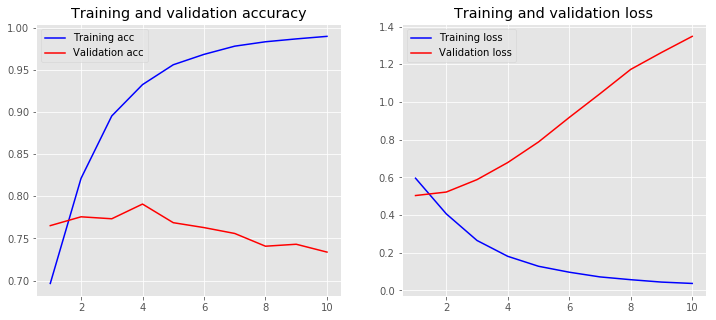

In [32]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=False)
val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Training accuracy: {:.4f}".format(train_accuracy), "\nTesting accuracy: {:.4f}".format(val_accuracy))

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
plot_history(history)

In [33]:
dnn_pred=model.predict(X_test)
lbls = ['OFF','NOT']
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(lbls)
p_classes=lb.inverse_transform(dnn_pred)
p_classes=encoder.fit_transform(p_classes)
matrix = metrics.confusion_matrix(y_test, p_classes)
matrix

array([[515, 105],
       [124, 116]], dtype=int64)

# 3 - name

In [34]:
train_x=tweets
valid_y=test_labels
valid_x=test_tweets
train_y=tweet_labels

In [35]:
# label encode the target variable 
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
df_training['tweet']
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df_training['tweet'])
# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(df_training['tweet'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x)

In [37]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    print(metrics.classification_report(valid_y, predictions))
    cm=confusion_matrix(y_test, predictions)
    return metrics.accuracy_score(predictions, valid_y), cm

In [38]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df_training['tweet'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(df_training['tweet'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(df_training['tweet'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

In [39]:
# Linear Classifier on Count Vectors
accuracy, cm = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print ("LR, Count Vectors: ", accuracy)
print(cm)
# Linear Classifier on Word Level TF IDF Vectors
accuracy, cm = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("LR, WordLevel TF-IDF: ", accuracy)
print(cm)
# Linear Classifier on Ngram Level TF IDF Vectors
accuracy, cm = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)
print(cm)
# Linear Classifier on Character Level TF IDF Vectors
accuracy, cm = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("LR, CharLevel Vectors: ", accuracy)
print(cm)

NameError: name 'linear_model' is not defined